In [1]:
import numpy as np
import matplotlib.pyplot as plt

def log_pi(x):
    # Log-density of standard normal (ignoring constant)
    return -0.5 * np.dot(x, x)

def q_sigma(x, sigma, size):
    # Proposal: N(x, sigma^2 I)
    return np.random.normal(loc=x, scale=sigma, size=(size, x.shape[0]))

def log_weight(y):
    return 0.5 * log_pi(y)

def mtm_step_log(x, sigma=1.0, N=5):
    # Step 1: sample N proposals
    y_candidates = q_sigma(x, sigma, N)
    log_ws = np.array([log_weight(y) for y in y_candidates])
    max_logw = np.max(log_ws)
    sum_y = np.log(np.sum(np.exp(log_ws - max_logw))) + max_logw
    ws = np.exp(log_ws - max_logw)
    probs = ws / ws.sum()
    j = np.random.choice(N, p=probs)
    y_j = y_candidates[j]

    # Step 2: sample N-1 backward proposals
    z_candidates = q_sigma(y_j, sigma, N-1)
    log_z_ws = np.array([log_weight(z) for z in z_candidates] + [log_weight(x)])
    max_logz = np.max(log_z_ws)
    sum_z = np.log(np.sum(np.exp(log_z_ws - max_logz))) + max_logz

    log_num = 0.5*log_pi(y_j) - 0.5 * np.dot(y_j - x, y_j - x) - sum_z
    log_den = 0.5*log_pi(x) - 0.5 * np.dot(x - y_j, x - y_j) - sum_y

    log_alpha = log_num - log_den
    alpha = min(1, np.exp(log_alpha))
    if np.random.rand() < alpha:
        return y_j, True
    else:
        return x, False

def metropolis_step_log(x, sigma=1.0):
    y = q_sigma(x, sigma, 1)[0]
    log_alpha = log_pi(y) - log_pi(x)
    alpha = min(1, np.exp(log_alpha))
    if np.random.rand() < alpha:
        return y, True
    else:
        return x, False

In [2]:
# Parameters
d = 100
steps = 10000
sigma = 1.0

# MTM sampling
x_mtm = np.random.normal(loc=2.0, scale=1.0, size=d)
samples_mtm = [x_mtm.copy()]
accepts_mtm = 0
for t in range(steps):
    x_new, accepted = mtm_step_log(samples_mtm[-1], sigma=sigma, N=10)
    samples_mtm.append(x_new.copy())
    accepts_mtm += int(accepted)
samples_mtm = np.array(samples_mtm)

# Metropolis sampling
x_met = np.random.normal(loc=2.0, scale=1.0, size=d) 
samples_met = [x_met.copy()]
accepts_met = 0
for t in range(steps):
    x_new, accepted = metropolis_step_log(samples_met[-1], sigma=sigma)
    samples_met.append(x_new.copy())
    accepts_met += int(accepted)
samples_met = np.array(samples_met)

# Mean convergence
mtm_means = np.mean(samples_mtm, axis=1)
met_means = np.mean(samples_met, axis=1)

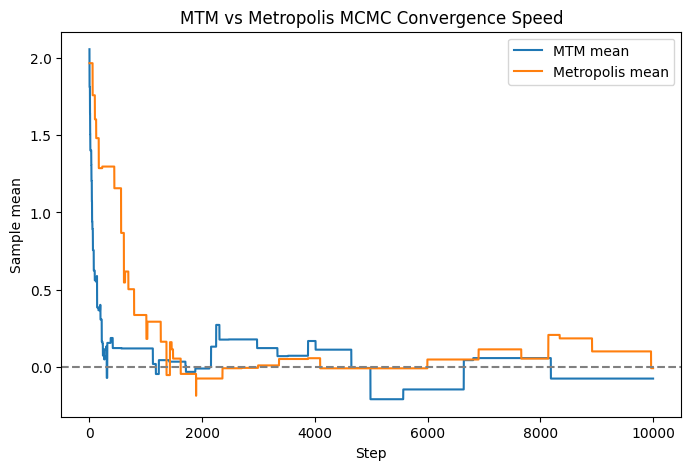

In [3]:
plt.figure(figsize=(8,5))
plt.plot(mtm_means, label='MTM mean')
plt.plot(met_means, label='Metropolis mean')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Sample mean')
plt.title('MTM vs Metropolis MCMC Convergence Speed')
plt.legend()
plt.show()